In [1]:

%matplotlib inline
from itertools import chain, combinations
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
from abc import ABC
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import nest_asyncio
nest_asyncio.apply()
from collections import defaultdict
from typing import Any

from sklearn import metrics
from matplotlib import pyplot as plt


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.bijectors as tfb

# pip install github:https://github.com/mederrata/bayesianquilts
from bayesianquilts.models.logistic_regression_reparam import LogisticRegression2
from bayesianquilts.metrics.classification import classification_metrics, auroc, auprc
from bayesianquilts.sampler import psis, nppsis


2024-10-11 20:23:30.205934: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 20:23:30.231429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 20:23:30.231458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 20:23:30.232385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 20:23:30.236866: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 20:23:30.237342: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:

X_ = pd.read_csv(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overianx.csv", header=None)
y_ = pd.read_table(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overiany.csv", header=None)


X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0).to_numpy()
y_ = y_.to_numpy()
N = X_scaled.shape[0]
d = X_scaled.shape[1]

print((N, d))

(54, 1536)


In [4]:
logistic_horseshoe_code = """
data {
  int <lower=0> N;                // number  of  observations
  int <lower=0> d;                // number  of  predictors
  array[N] int<lower=0,upper=1> y;      // outputs
  matrix[N,d] x;                  // inputs
  real <lower=0>  scale_icept;    // prior  std for  the  intercept
  real <lower=0>  scale_global;   // scale  for  the half -t prior  for  tau
  real <lower=1>  nu_global;      // degrees  of  freedom  for the half -t prior for tau
  real <lower=1> nu_local;        // degrees  of  freedom  for  the half -t priors for  lambdas
  real <lower=0>  slab_scale;     // slab  scale  for  the  regularized  horseshoe
  real <lower=0> slab_df;         // slab  degrees  of  freedom  for the  regularized horseshoe

  //int<lower=0> N_tilde;
  //matrix[N_tilde, d] x_tilde;
  //array[N_tilde] int<lower=0,upper=1> y_obs;
}
parameters {
  real  beta0;
  vector[d] z;
  real <lower=0> tau;             // global  shrinkage  parameter
  vector <lower =0>[d] lambda;    // local  shrinkage  parameter
  real <lower=0> caux;
}
transformed  parameters {
  vector <lower =0>[d] lambda_tilde;    // ’truncated ’ local  shrinkage  parameter
  real <lower=0> c;                     // slab  scale
  vector[d] beta;                       // regression  coefficients
  vector[N] f;                          // latent  function  values
  c = slab_scale * sqrt(caux);
  lambda_tilde = sqrt( c^2 * square(lambda) ./ (c^2 + tau^2* square(lambda )) );
  beta = z .*  lambda_tilde*tau;
  f = beta0 + x*beta;
}
model {
  z ~ normal(0.0, 1.0); // half -t priors  for  lambdas  and tau , and  inverse -gamma  for c^2
  lambda ~ student_t(nu_local , 0.0, 1.0);
  tau ~ student_t(nu_global , 0.0, scale_global);
  caux ~ inv_gamma (0.5* slab_df , 0.5* slab_df );
  beta0 ~ normal(0.0,  scale_icept );
  y ~ bernoulli_logit(f);
}
generated quantities {
  vector[N] log_lik;
  // vector[N_tilde] loo_log_lik;

  for (nn in 1:N)
    log_lik[nn] = bernoulli_logit_lpmf(y[nn] | x[nn] * beta + beta0);

  //for (nn in 1:N_tilde)
  //  loo_log_lik[nn] = bernoulli_logit_lpmf(y_obs[nn] | x_tilde[nn] * beta + beta0);
}
"""

with open("ovarian_model.stan", 'w') as f:
  f.writelines(logistic_horseshoe_code)


In [5]:
sm = CmdStanModel(stan_file="ovarian_model.stan")

20:23:31 - cmdstanpy - INFO - compiling stan file /home/josh/workspace/bayesianquilts/ovarian_model.stan to exe file /home/josh/workspace/bayesianquilts/ovarian_model
20:23:48 - cmdstanpy - INFO - compiled model executable: /home/josh/workspace/bayesianquilts/ovarian_model


In [6]:
guessnumrelevcov = N / 10  # 20.
slab_scale = 2.5
scale_icept = 5.0
nu_global = 1
nu_local = 1
slab_df = 1
scale_global = guessnumrelevcov / ((d - guessnumrelevcov) * np.sqrt(N))

control = {"adapt_delta": 0.9999, "max_treedepth": 15}

# shuffle

# shuffled_ndx = np.random.shuffle(np.arange(N))

ovarian_data = {
    "N": N,
    "d": d,
    "slab_df": slab_df,
    "slab_scale": slab_scale,
    "scale_icept": scale_icept,
    "nu_global": 1,
    "nu_local": 1,
    "scale_global": scale_global,
    "y": y_.astype(int)[:, 0].tolist(),
    "x": X_scaled.tolist(),
}

import json

with open("ovarian_data.json", "w") as f:
    json.dump(ovarian_data, f)

In [7]:
print(d)

1536


In [8]:
S = 1800
fit = sm.sample(
    data="ovarian_data.json",
    iter_warmup=15000,
    iter_sampling=S,
    thin=2,
    **control
)

20:23:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:15 - cmdstanpy - INFO - CmdStan done processing.
20:45:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[1] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', line 26, column 2 to column 36)
Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[1] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', line 26, column 2 to column 36)
Consider re-running with show_console=True if the above output is unclear!


In [9]:
print(fit)

CmdStanMCMC: model=ovarian_model chains=4['method=sample', 'num_samples=1800', 'num_warmup=15000', 'thin=2', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'adapt', 'engaged=1', 'delta=0.9999']
 csv_files:
	/tmp/tmpvxduruuy/ovarian_modeltrqh1udq/ovarian_model-20241011202348_1.csv
	/tmp/tmpvxduruuy/ovarian_modeltrqh1udq/ovarian_model-20241011202348_2.csv
	/tmp/tmpvxduruuy/ovarian_modeltrqh1udq/ovarian_model-20241011202348_3.csv
	/tmp/tmpvxduruuy/ovarian_modeltrqh1udq/ovarian_model-20241011202348_4.csv
 output_files:
	/tmp/tmpvxduruuy/ovarian_modeltrqh1udq/ovarian_model-20241011202348_0-stdout.txt
	/tmp/tmpvxduruuy/ovarian_modeltrqh1udq/ovarian_model-20241011202348_1-stdout.txt
	/tmp/tmpvxduruuy/ovarian_modeltrqh1udq/ovarian_model-20241011202348_2-stdout.txt
	/tmp/tmpvxduruuy/ovarian_modeltrqh1udq/ovarian_model-20241011202348_3-stdout.txt


In [10]:
print(fit.diagnose())

Processing csv files: /tmp/tmpvxduruuy/ovarian_modeltrqh1udq/ovarian_model-20241011202348_1.csv, /tmp/tmpvxduruuy/ovarian_modeltrqh1udq/ovarian_model-20241011202348_2.csv, /tmp/tmpvxduruuy/ovarian_modeltrqh1udq/ovarian_model-20241011202348_3.csv, /tmp/tmpvxduruuy/ovarian_modeltrqh1udq/ovarian_model-20241011202348_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [11]:
params = fit.stan_variables()
params.keys()
params['c'] = params['c'][:, tf.newaxis]
params['tau'] = params['tau'][:, tf.newaxis]
params['caux'] = params['caux'][:, tf.newaxis]
params['beta0'] = params['beta0'][:, tf.newaxis]


In [12]:

c = slab_scale * tf.math.sqrt(params["caux"])
lambda_tilde = tf.math.sqrt(
    c**2
    * params["lambda"] ** 2
    / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
)
beta_fitted = params["z"] * lambda_tilde * params["tau"]
beta_fitted.shape

TensorShape([3600, 1536])

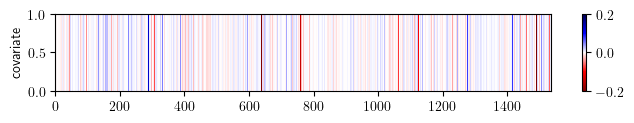

In [13]:
beta_fitted = np.mean(beta_fitted, axis=0, keepdims=True)
fig, ax = plt.subplots(1, 1, figsize=(8, 1))
im = ax.pcolormesh(beta_fitted, cmap='seismic_r', vmin=-0.2, vmax=0.2)
_ = plt.ylabel("covariate")

plt.colorbar(im)
plt.savefig("ovarian_mcmc_fit.pdf", bbox_inches='tight')

In [14]:
lr_model = LogisticRegression2(
    dim_regressors=d,
    slab_df=slab_df,
    slab_scale=slab_scale,
    scale_icept=scale_icept,
    nu_global=1,
    nu_local=1,
    scale_global=scale_global,
)

In [15]:
tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})
batch_size = N
def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

batch = next(iter(data_factory_factory()()))

0it [00:00, ?it/s]2024-10-11 20:45:30.365910: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2388787200 exceeds 10% of free system memory.
1it [00:00,  2.08it/s]


(0.0, 1.0)

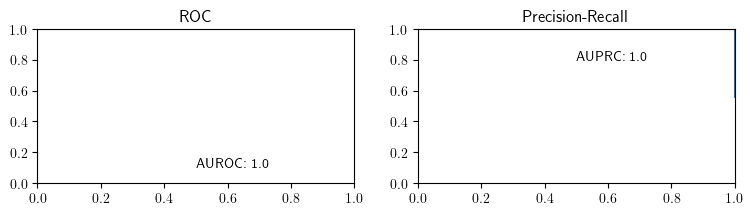

In [16]:
def prediction_fn(data):
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [17]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def adaptive_is_loo(
    self: LogisticRegression2,
    data: dict[str, tf.Tensor],
    params,
    hbar=1.0,
    variational=True,
) -> dict[str, Any]:
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    c = self.slab_scale * tf.math.sqrt(params["caux"])
    lambda_tilde = tf.math.sqrt(
        c**2
        * params["lambda"] ** 2
        / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
    )
    beta = params["z"] * lambda_tilde * params["tau"]
    intercept = params["beta0"]
    _X = tf.cast(data["X"], self.dtype)
    _y = tf.cast(data["y"], self.dtype)[:, 0]
    mu = beta[..., tf.newaxis, :] * _X
    mu = tf.reduce_sum(mu, -1) + params["beta0"]
    sigma = tf.math.sigmoid(mu)
    ell = _y * (sigma) + (1 - _y) * (1 - sigma)
    log_ell = tf.math.xlogy(_y, sigma) + tf.math.xlogy(1 - _y, 1 - sigma)
    log_ell_prime = _y * (1 - sigma) - (1 - _y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)
    _, khat0 = nppsis.psislw(-log_ell)

    """
    sigma.shape is samples x datapoints
    """

    ndx_to_transform = np.where(khat0 > 0.7)[0]
    ndx_to_leave = np.where((khat0 <= 0.7))[0]

    def IS(T, X, y):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)
        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
        log_ell_doubleprime = -sigma * (1 - sigma)
        # compute # \nabla\log\pi(\btheta|\calD)
        if variational:
            # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
            grad_log_pi = tf.concat(
                [
                    -(
                        intercept
                        - self.surrogate_distribution.model["intercept__"].mean()
                    )
                    / self.surrogate_distribution.model["intercept__"].variance(),
                    -(beta - self.surrogate_distribution.model["beta__"].mean())
                    / self.surrogate_distribution.model["beta__"].variance(),
                ],
                axis=-1,
            )
            intercept_sd = (
                self.surrogate_distribution.model["intercept__"].variance() ** 0.5
            )
            beta_sd = self.surrogate_distribution.model["beta__"].variance() ** 0.5

            log_pi = self.surrogate_distribution.model["beta__"].log_prob(
                params["beta__"]
            ) + self.surrogate_distribution.model["intercept__"].log_prob(
                params["intercept__"]
            )
            log_pi -= tf.reduce_max(log_pi, axis=0)
            # log_pi.shape: [samples]
        else:
            """
            Recall Bayes rule:
            \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

            so
            \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

            """
            log_prior = self.prior_distribution.log_prob_parts(params)
            log_prior = log_prior["z"] + log_prior["beta0"]

            log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]

            # pi \propto
            grad_log_pi = tf.concat(
                [
                    tf.reduce_sum(
                        log_ell_prime[..., tf.newaxis], axis=1, keepdims=True
                    ),
                    tf.reduce_sum(
                        log_ell_prime[..., tf.newaxis] * X, axis=1, keepdims=True
                    ),
                ],
                axis=-1,
            )

            grad_log_prior = -0.5 * tf.concat(
                [(params["beta0"] / self.scale_icept) ** 2, (params["z"]) ** 2],
                axis=-1,
            )
            grad_log_pi += grad_log_prior[:, tf.newaxis, :]

            intercept_sd = tf.math.reduce_std(intercept, 0, keepdims=True)
            beta_sd = tf.math.reduce_std(beta, 0, keepdims=True)

        beta_new, intercept_new, logJ = T(
            X,
            y,
            log_pi=log_pi,
            grad_log_pi=grad_log_pi,
            beta_sd=beta_sd,
            intercept_sd=intercept_sd,
        )
        mu_new = tf.reduce_sum(beta_new * X, axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.sqrt(
            c**2
            * params["lambda"] ** 2
            / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
        )
        transformed = params.copy()
        transformed["z"] = beta_new / (
            lambda_tilde[:, tf.newaxis, :] * params["tau"][..., tf.newaxis]
        )
        transformed["beta0"] = intercept_new

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )
            pass
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = tf.math.sigmoid(
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * X, -1) + intercept_new
            )
            ell_cross = tf.math.xlogy(y, ell_cross) + tf.math.xlogy(
                1 - y, 1 - ell_cross
            )
            ell_cross = tf.math.reduce_sum(ell_cross, axis=-1)

            log_prior_new = self.prior_distribution.log_prob_parts(transformed)
            log_prior_new = log_prior_new["z"] + log_prior_new["beta0"]
            log_pi_new = ell_cross
            delta_log_prior = log_prior_new - log_prior[:, tf.newaxis]
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi[:, tf.newaxis] + delta_log_prior

        # regularize delta_log_pi

        def regularize(tensor):
            min_finite = tf.reduce_min(
                tf.where(
                    tf.math.is_finite(tensor),
                    tensor,
                    tf.zeros_like(tensor),
                )
            )
            return tf.where(
                tf.math.is_finite(tensor),
                tensor,
                min_finite * tf.ones_like(tensor),
            )

        delta_log_pi = regularize(delta_log_pi)
        delta_log_pi -= tf.reduce_max(delta_log_pi, axis=0)
        log_eta_weights = delta_log_pi - regularize(log_ell_new) + logJ
        log_eta_weights = log_eta_weights - tf.reduce_max(log_eta_weights, axis=0)
        psis_weights, khat = nppsis.psislw(log_eta_weights)

        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = self.entropy(eta_weights)
        psis_entropy = self.entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )

    # log-likelihood descent

    def T_ll(X, y, log_pi, beta_sd, intercept_sd, **kwargs):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)

        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma

        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized
        logJ = tf.math.log1p(
            tf.math.abs(
                h
                * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :]
                * (sigma * (1 - sigma))[..., tf.newaxis]
            )[..., 0]
        )
        beta_ll = beta[..., tf.newaxis, :] + h * Q_beta
        intercept_ll = intercept[..., tf.newaxis, :] + h * Q_intercept
        return beta_ll, intercept_ll, logJ

    def T_kl(X, y, log_pi, grad_log_pi, beta_sd, intercept_sd):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        Q_beta = ((-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ] * X
        Q_intercept = (
            ((-1) ** y) * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (-1) ** y[tf.newaxis, :] * tf.math.exp(
            log_pi_[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :])
        )
        dQ *= (
            grad_log_pi[..., 0]
            + (1 - 2 * y)[tf.newaxis, :]
            + tf.reduce_sum(
                X
                * (
                    grad_log_pi[..., 1:]
                    + (1 - 2 * y)[:, tf.newaxis] * X[tf.newaxis, ...]
                ),
                axis=-1,
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def T_I(X, y, **kwargs):
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)

        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        Q = tf.zeros_like(log_ell)
        return (
            beta[:, tf.newaxis, :] + Q[..., tf.newaxis],
            intercept[..., tf.newaxis] + Q[..., tf.newaxis],
            tf.zeros_like(Q),
        )

    def T_var(X, y, log_pi, grad_log_pi, beta_sd, intercept_sd, **kwargs):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        Q_beta = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis] * X
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(
                log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y[tf.newaxis, :])
            )
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + 2 * (1 - 2 * y)[:, tf.newaxis] * X),
                    axis=-1,
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis, :] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def T_MM1(X, y, **kwargs):
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.abs(c) / tf.math.sqrt(
            (c / params["lambda"]) ** 2 + params["tau"] ** 2
        )
        beta = params["z"] * lambda_tilde * params["tau"]
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_hat(param):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        beta_hat, beta_hat_w, beta_v, beta_v_w = theta_hat(beta)
        beta0_hat, beta0_hat_w, beta0_v, beta0_v_w = theta_hat(params["beta0"])

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        beta_adj = beta[:, tf.newaxis, ...] + hbar * (-beta_hat + beta_hat_w)
        beta0_adj = params["beta0"][:, tf.newaxis, ...] + hbar * (
            -beta0_hat + beta0_hat_w
        )

        # shift by mean
        return beta_adj, beta0_adj, tf.zeros_like(ell)

    def T_MM2(X, y, **kwargs):
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.abs(c) / tf.math.sqrt(
            (c / params["lambda"]) ** 2 + params["tau"] ** 2
        )
        beta = params["z"] * lambda_tilde * params["tau"]
        mu = beta[..., tf.newaxis, :] * X
        mu = tf.reduce_sum(mu, -1) + params["beta0"]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_hat(param):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        beta_hat, beta_hat_w, beta_v, beta_v_w = theta_hat(beta)
        beta0_hat, beta0_hat_w, beta0_v, beta0_v_w = theta_hat(params["beta0"])

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        beta_adj = beta[:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(beta_v_w / beta_v) - 1) * beta[:, tf.newaxis, ...]
            - tf.math.sqrt(beta_v_w / beta_v) * beta_hat
            + beta_hat_w
        )
        beta0_adj = params["beta0"][:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(beta0_v_w / beta0_v) - 1)
            * params["beta0"][:, tf.newaxis, ...]
            - tf.math.sqrt(beta0_v_w / beta0_v) * beta0_hat
            + beta0_hat_w
        )

        lJ = tf.math.log(
            1
            + hbar
            * (
                beta.shape[-1]
                * tf.ones_like(ell)
                * (tf.math.sqrt(beta0_v_w / beta0_v) - 1)[..., 0]
            )
        )
        lJ += tf.math.log(1 + hbar * (tf.math.sqrt(beta0_v_w / beta0_v) - 1)[..., 0])

        # shift by mean
        return beta_adj, beta0_adj, lJ

    X_ = tf.gather(_X, ndx_to_leave)
    y_ = tf.gather(_y, ndx_to_leave)
    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I, X_, y_)

    out = {
        "I0": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
            "ndx": ndx_to_leave,
        }
    }

    transforms = {
        "MM1": T_MM1,
        "MM2": T_MM2,
        "I": T_I,
        "KL": T_kl,
        "Var": T_var,
        "LL": T_ll,
    }

    X_ = tf.gather(_X, ndx_to_transform)
    y_ = tf.gather(_y, ndx_to_transform)
    for lab, fun in transforms.items():
        (
            eta_,
            eta_psis_,
            p_loo_,
            p_loo_sd_,
            ll_loo_,
            ll_loo_s_d,
            S_,
            k_,
            p_psis_,
            ll_psis_,
        ) = IS(fun, X_, y_)

        out = {
            **out,
            lab: {
                "p_loo": p_loo_,
                "p_loo_sd": p_loo_sd_,
                "ll_loo": ll_loo_,
                "ll_loo_sd": ll_loo_s_d,
                "S": S_,
                "khat": k_,
                "p_psis": p_psis_,
                "ll_psis": ll_psis_,
                "ndx": ndx_to_transform,
            },
        }

    return {**out, "ndx_transformed": ndx_to_transform}


nparams = 64
loo = adaptive_is_loo(
    lr_model,
    batch,
    {k: v[:nparams, ...] for k, v in params.items()},
    1e-5,
    variational=False,
)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var", "MM1", "MM2"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
    )

I: 0.0572555016823031 entropy: 11.472210090956791 khat>0.7: 33
LL: 0.054469664936295355 entropy: 11.473874343860444 khat>0.7: 32
KL: 0.05379714896993137 entropy: 11.476496270336671 khat>0.7: 33
Var: 0.05264306312153696 entropy: 11.480192486099119 khat>0.7: 33
MM1: 0.06056472000893017 entropy: 11.41124791816632 khat>0.7: 30
MM2: 0.06556404930635026 entropy: 11.205072816657507 khat>0.7: 9


In [18]:
base = 4
h_vals = [base**-r for r in range(11)]

loo_output = []

for _ in tqdm(range(1)):
    loo_khat = {}
    reduced_ndx = {}
    high_khat_ndx = {}
    n_sample = [1000]
    records = []
    for n_samples in n_sample:
        sample_ndx = np.random.choice(range(fit.stan_variables()['beta0'].shape[0]), size=n_samples, replace=False)
        reduced_ndx[n_samples] = {}
        high_khat_ndx[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat[n_samples] = {}
        params_ = fit.stan_variables()
        params_ = {k: v[sample_ndx] for k, v in params_.items()}

        params_["c"] = params_["c"][:, tf.newaxis]
        params_["tau"] = params_["tau"][:, tf.newaxis]
        params_["caux"] = params_["caux"][:, tf.newaxis]
        params_["beta0"] = params_["beta0"][:, tf.newaxis]

        for h in h_vals:
            loo_khat[n_samples][h] = {}
            loo = adaptive_is_loo(lr_model, batch, params_, h, variational=False)
            reduced_ndx[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I", "LL", "KL", "Var", "MM1", "MM2"]:
                loo_khat[n_samples][h][T] = np.array(loo[T]["khat"])

                records += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"]
                    }
                ]
                reduced_ndx[n_samples][h][T] = [loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]]
                # print(reduced_ndx[n_samples][h])


print(reduced_ndx)

  0%|          | 0/1 [00:00<?, ?it/s]2024-10-11 20:45:32.878017: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 7077888000 exceeds 10% of free system memory.
2024-10-11 20:45:34.431998: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 11059200000 exceeds 10% of free system memory.
2024-10-11 20:45:37.481916: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 11059200000 exceeds 10% of free system memory.
2024-10-11 20:45:39.558875: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 11059200000 exceeds 10% of free system memory.
100%|██████████| 1/1 [02:53<00:00, 173.37s/it]

{1000: {1: {'I0': [0, 2, 3, 4, 5, 7, 10, 11, 12, 13, 16, 18, 19, 20, 24, 31, 32, 34, 35, 36, 39, 42, 44, 52], 'I': [], 'LL': [27], 'KL': [], 'Var': [14, 23], 'MM1': [], 'MM2': []}, 0.25: {'I0': [0, 2, 3, 4, 5, 7, 10, 11, 12, 13, 16, 18, 19, 20, 24, 31, 32, 34, 35, 36, 39, 42, 44, 52], 'I': [], 'LL': [], 'KL': [], 'Var': [9, 15], 'MM1': [49, 53], 'MM2': []}, 0.0625: {'I0': [0, 2, 3, 4, 5, 7, 10, 11, 12, 13, 16, 18, 19, 20, 24, 31, 32, 34, 35, 36, 39, 42, 44, 52], 'I': [], 'LL': [17], 'KL': [28, 30], 'Var': [9, 22, 46], 'MM1': [6, 8, 21, 26, 28, 33, 40, 43, 45, 48, 50], 'MM2': []}, 0.015625: {'I0': [0, 2, 3, 4, 5, 7, 10, 11, 12, 13, 16, 18, 19, 20, 24, 31, 32, 34, 35, 36, 39, 42, 44, 52], 'I': [], 'LL': [], 'KL': [15, 47], 'Var': [1, 9, 23, 30], 'MM1': [6, 8, 15, 21, 22, 25, 26, 27, 29, 33, 38, 40, 41, 43, 47, 50, 53], 'MM2': []}, 0.00390625: {'I0': [0, 2, 3, 4, 5, 7, 10, 11, 12, 13, 16, 18, 19, 20, 24, 31, 32, 34, 35, 36, 39, 42, 44, 52], 'I': [], 'LL': [1, 26], 'KL': [6, 8, 17, 21, 22,

## Look at S=1000 case

In [19]:
df = pd.DataFrame(records)
df['rho_rank'] = np.emath.logn(base, df['h']) 
df.head()
I0_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="I0")]

kl_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="KL")]
var_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="Var")]
ll_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="LL")]
mm1_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="MM1")]
I_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="I")]

kl_ = kl_.explode(['khat', 'ndx'])
var_ = var_.explode(['khat', 'ndx'])
ll_ = ll_.explode(['khat', 'ndx'])
I_ = I_.explode(['khat', 'ndx'])
mm1_ = mm1_.explode(['khat', 'ndx'])

original = I_[['khat', 'ndx']].drop_duplicates()


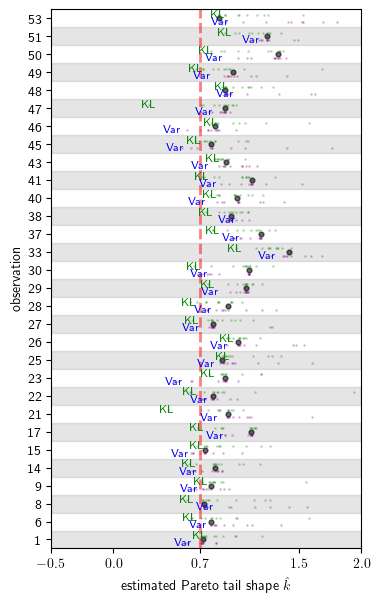

In [20]:
fig = plt.figure(figsize=(4, 7))
ndx_high_khat = loo['KL']['ndx'].tolist()
ymax = (len(ndx_high_khat))
_ = plt.scatter(original.khat, np.array([ndx_high_khat.index(i) for i in original['ndx']]) ,color="black", s=12, alpha=0.6)
_ = plt.scatter(kl_.khat, np.array([ndx_high_khat.index(i) for i in kl_['ndx']]) + 0.2, s=1, color='green', alpha=0.2)
_ = plt.scatter(var_.khat, np.array([ndx_high_khat.index(i) for i in var_['ndx']]) - 0.2, s=1, color='purple', alpha=0.2)

kl_ = kl_[kl_.khat<3]
ll_ = ll_[ll_.khat<3]
var_ = var_[var_.khat<3]
_ = plt.axvline(x=0.7, linestyle='dashed', linewidth=2, color='red', alpha=0.5)

kl_vals = defaultdict(list)
var_vals = defaultdict(list)
ll_vals = defaultdict(list)

for x, y, s in zip( kl_.khat, kl_['ndx'], kl_['rho_rank'].values.astype('int')):
    kl_vals[y] += [x]
    
for x, y, s in zip( var_.khat, var_['ndx'], var_['rho_rank'].values.astype('int')):
    var_vals[y] += [x]

for x, v in kl_vals.items():
    plt.plot(min(v), ndx_high_khat.index(x)+0.2, color='green', alpha=0.3)
    plt.text(min(v), ndx_high_khat.index(x) + 0.2, "KL",  ha='center', va='center', color='green', fontsize=8)
    
for x, v in var_vals.items():
    plt.plot(min(v), ndx_high_khat.index(x)-0.2, color='purple', alpha=0.3)
    plt.text(min(v), ndx_high_khat.index(x)-0.2, "Var",  ha='center', va='center', color='blue', fontsize=8)
    
    
#for x, v in var_vals.items():
#    plt.text(min(v), x, "LL",  ha='center', va='center', color='purple', fontsize=8)

_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax - 0.5)
_ = plt.xlabel(r'estimated Pareto tail shape $\hat{k}$')
_ = plt.yticks(ticks=np.arange(ymax), labels=loo['KL']['ndx'])
_ = plt.xlim((-0.5, 2))
_ = plt.xticks([-0.5, 0, 0.7, 1.5, 2])


for y0, y1 in zip(np.arange(ymax+ 1)[::2]-0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color='black', alpha=0.1, zorder=0)
#_ = plt.xlim((-0.1, 2))
_ = plt.savefig("khat.pdf", bbox_inches='tight')

In [21]:
len(ndx_high_khat)

30

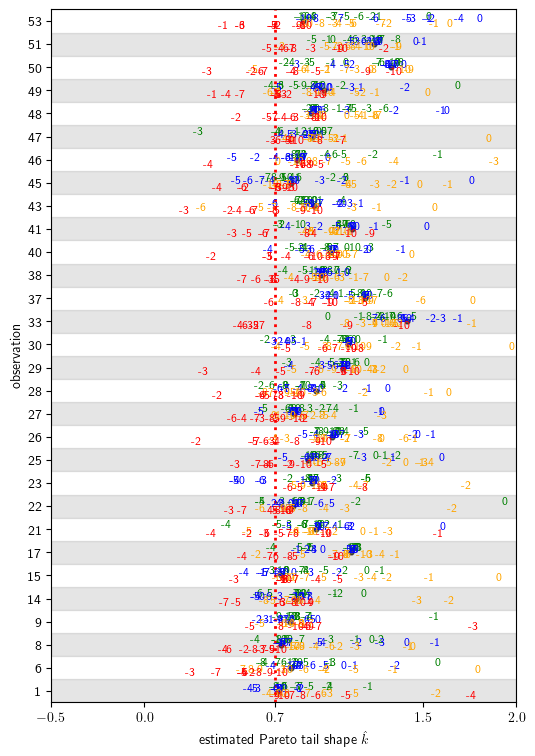

In [22]:
fig = plt.figure(figsize=(6, 9))

_ = plt.scatter(original.khat, np.array([ndx_high_khat.index(i) for i in original['ndx']]) ,color="black", s=12, alpha=0.6)
_ = plt.scatter(kl_.khat, np.array([ndx_high_khat.index(i) for i in kl_['ndx']]), s=0, color='green', alpha=0.2)
_ = plt.scatter(var_.khat, np.array([ndx_high_khat.index(i) for i in var_['ndx']]), s=0, color='purple', alpha=0.2)
_ = plt.scatter(ll_.khat, np.array([ndx_high_khat.index(i) for i in ll_['ndx']]), s=0, color='green', alpha=0.2)
_ = plt.scatter(mm1_.khat, np.array([ndx_high_khat.index(i) for i in mm1_['ndx']]), s=0, color='purple', alpha=0.2)

kl_ = kl_[kl_.khat<2]
ll_ = ll_[ll_.khat<2]
var_ = var_[var_.khat<2]
mm1_ = mm1_[mm1_.khat<2]
_ = plt.axvline(x=0.7, linestyle='dotted', linewidth=2, color='red')

for x, y, s in zip( kl_.khat, kl_['ndx'], kl_['rho_rank'].values.astype('int')):
    if s > 7:
        continue
    plt.text(x, ndx_high_khat.index(y) + 0.2, str(s),  ha='center', va='center', color='green', fontsize=8)
    
for x, y, s in zip( var_.khat, var_['ndx'], var_['rho_rank'].values.astype('int')):
    if s > 7:
        continue
    plt.text(x, ndx_high_khat.index(y) + 0.1, str(s),  ha='center', va='center', color='blue', fontsize=8)

for x, y, s in zip( ll_.khat, ll_['ndx'], ll_['rho_rank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, ndx_high_khat.index(y) - 0.1, str(s),  ha='center', va='center', color='orange', fontsize=8)

for x, y, s in zip( mm1_.khat, mm1_['ndx'], mm1_['rho_rank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, ndx_high_khat.index(y) - 0.2, str(s),  ha='center', va='center', color='red', fontsize=8)
    
_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax - 0.5)
_ = plt.xlabel(r'estimated Pareto tail shape $\hat{k}$')
_ = plt.yticks(ticks=np.arange(ymax), labels=loo['KL']['ndx'])
_ = plt.xlim((-0.5, 2))
_ = plt.xticks([-0.5, 0, 0.7, 1.5, 2])


for y0, y1 in zip(np.arange(ymax+ 1)[::2]-0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color='black', alpha=0.1, zorder=0)
#_ = plt.xlim((-0.1, 2))
_ = plt.savefig("khat_detailed.pdf", bbox_inches='tight')

In [23]:
df_ = df.explode(['khat', "p_psis", 'ndx'])[['ndx', 'p_psis', 'khat', 'T']]
#df_ = df_[df_['p_psis']!=1]
#df_ = df_[df_['p_psis']>1e-5]
df_ = df_[df_['T']!="MM2"]

df_ = df_.groupby(['ndx'])[['khat', 'p_psis']].min()

pd.set_option('display.max_rows', 500)

df_ = df_.reset_index()
df_['y'] = [y_.tolist()[i][0] for i in df_['ndx'].values]


In [24]:
fpr, tpr, thresholds = metrics.roc_curve(df_['y'], df_.p_psis, pos_label=1)
precision, recall, thresholds_pr = metrics.precision_recall_curve(df_['y'], df_.p_psis)

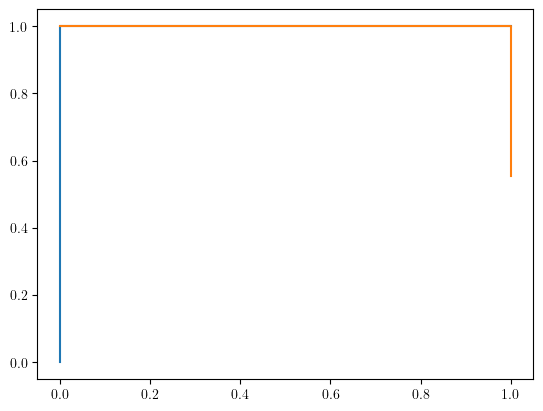

In [25]:
plt.plot(fpr, tpr)
plt.plot(recall, precision)

# Cross-tabulations

In [26]:
df__ = df.explode(['khat', 'ndx'])[['ndx', 'khat', 'T']]
transforms = ["KL", "Var", "LL", "MM1", "MM2"]


In [27]:
for T in transforms:
    _df__ = df__.loc[(df__['T']==T) & (df__['khat']<0.7)]
    print(f"{T}: {_df__.groupby('ndx').min().shape[0]}")
print(len(df__[df__['T']!="I0"].ndx.unique()))

KL: 14
Var: 13
LL: 14
MM1: 27
MM2: 26
30


In [28]:
print(f"{df__.loc[((df__['T']=='KL') | (df__['T']=='Var')) & (df__['khat']<0.7)].groupby('ndx').min().shape[0]}")

19


In [29]:
print(f"{df__.loc[((df__['T']=='LL') | (df__['T']=='MM1')) &(df__['T']!='I0') & (df__['khat']<0.7)].groupby('ndx').min().shape[0]}")

28


In [30]:
print(f"{df__.loc[(df__['T']!='MM1') &(df__['T']!='I0') & (df__['khat']<0.7)].groupby('ndx').min().shape[0]}")

28


In [31]:
len(df__[df__['T']!="I0"].ndx.unique())

30

# Compare with variational model

In [32]:
lr_model2 = LogisticRegression2(
    dim_regressors=d,
    slab_df=slab_df,
    slab_scale=slab_scale,
    scale_icept=scale_icept,
    nu_global=1,
    nu_local=1,
    scale_global=scale_global,
)

In [33]:

losses = lr_model2.fit(
    data_factory_factory(shuffle=True, repeat=True),
    dataset_size=N,
    batches_per_step=9,
    check_every=int(N/batch_size)*50,
    batch_size=batch_size,
    num_steps=10000,
    max_decay_steps=10,
    max_plateau_epochs=100,
    sample_size=36,
    learning_rate=0.0005,
    lr_decay_factor=0.9
    )



Running optimization for 10000 steps of 9 accumulated batches, checking every 50 steps
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-1


  0%|          | 48/10000 [00:05<14:00, 11.83it/s] 

Step 50: average-batch loss:15010.827783455745 rel loss: 6.661857789762632e+303
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-2


  1%|          | 98/10000 [00:09<14:05, 11.71it/s]

Step 100: average-batch loss:14902.18485517416 rel loss: 0.00729040267165003
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-3


  1%|▏         | 148/10000 [00:13<13:59, 11.74it/s]

Step 150: average-batch loss:14795.594792249476 rel loss: 0.00720417559559826
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-4


  2%|▏         | 198/10000 [00:18<14:01, 11.65it/s]

Step 200: average-batch loss:14687.969348080527 rel loss: 0.007327455662413521
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-5


  2%|▏         | 248/10000 [00:22<13:52, 11.71it/s]

Step 250: average-batch loss:14585.67191715563 rel loss: 0.007013556283586403
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-6


  3%|▎         | 298/10000 [00:26<13:35, 11.90it/s]

Step 300: average-batch loss:14480.111914250325 rel loss: 0.007289999105698961
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-7


  3%|▎         | 348/10000 [00:31<13:34, 11.86it/s]

Step 350: average-batch loss:14380.62008644131 rel loss: 0.006918465769276578
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-8


  4%|▍         | 398/10000 [00:35<13:33, 11.80it/s]

Step 400: average-batch loss:14278.095968530648 rel loss: 0.007180517495934174
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-9


  4%|▍         | 448/10000 [00:39<13:30, 11.79it/s]

Step 450: average-batch loss:14176.615410843455 rel loss: 0.007158306460763009
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-10


  5%|▍         | 498/10000 [00:43<13:35, 11.66it/s]

Step 500: average-batch loss:14076.702848073039 rel loss: 0.007097724790297265
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-11


  5%|▌         | 548/10000 [00:48<13:19, 11.83it/s]

Step 550: average-batch loss:13969.256049111524 rel loss: 0.0076916622176417815
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-12


  6%|▌         | 598/10000 [00:52<13:17, 11.79it/s]

Step 600: average-batch loss:13877.290046566795 rel loss: 0.006627086573540377
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-13


  6%|▋         | 648/10000 [00:56<13:18, 11.71it/s]

Step 650: average-batch loss:13779.708364616972 rel loss: 0.00708154914224381
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-14


  7%|▋         | 698/10000 [01:01<13:02, 11.89it/s]

Step 700: average-batch loss:13675.10090945129 rel loss: 0.007649483236601535
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-15


  7%|▋         | 748/10000 [01:05<13:02, 11.83it/s]

Step 750: average-batch loss:13575.70539744934 rel loss: 0.0073215725512595295
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-16


  8%|▊         | 798/10000 [01:09<13:24, 11.44it/s]

Step 800: average-batch loss:13478.383839365133 rel loss: 0.007220565851520535
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-17


  8%|▊         | 848/10000 [01:14<13:07, 11.63it/s]

Step 850: average-batch loss:13384.409211069764 rel loss: 0.007021201071590535
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-18


  9%|▉         | 898/10000 [01:18<12:49, 11.84it/s]

Step 900: average-batch loss:13288.033697719735 rel loss: 0.0072528047070325626
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-19


  9%|▉         | 948/10000 [01:22<12:46, 11.80it/s]

Step 950: average-batch loss:13195.871420650752 rel loss: 0.0069841751356226715
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-20


 10%|▉         | 998/10000 [01:27<12:41, 11.83it/s]

Step 1000: average-batch loss:13098.683731294082 rel loss: 0.007419653100294218
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-21


 10%|█         | 1048/10000 [01:31<12:33, 11.87it/s]

Step 1050: average-batch loss:13006.370466635126 rel loss: 0.0070975423078840595
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-22


 11%|█         | 1098/10000 [01:35<13:37, 10.89it/s]

Step 1100: average-batch loss:12911.562732733017 rel loss: 0.007342855072202488
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-23


 11%|█▏        | 1148/10000 [01:39<12:30, 11.80it/s]

Step 1150: average-batch loss:12815.189890918058 rel loss: 0.007520203963833308
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-24


 12%|█▏        | 1198/10000 [01:44<12:30, 11.73it/s]

Step 1200: average-batch loss:12719.507928659037 rel loss: 0.007522457849445152
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-25


 12%|█▏        | 1248/10000 [01:48<12:14, 11.91it/s]

Step 1250: average-batch loss:12630.577923259985 rel loss: 0.0070408500655604845
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-26


 13%|█▎        | 1298/10000 [01:52<12:10, 11.91it/s]

Step 1300: average-batch loss:12536.423615568901 rel loss: 0.007510459966760717
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-27


 13%|█▎        | 1348/10000 [01:56<12:14, 11.77it/s]

Step 1350: average-batch loss:12439.994630129608 rel loss: 0.00775152950675261
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-28


 14%|█▍        | 1398/10000 [02:01<13:01, 11.00it/s]

Step 1400: average-batch loss:12349.68039250823 rel loss: 0.007313082990889881
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-29


 14%|█▍        | 1448/10000 [02:05<12:05, 11.79it/s]

Step 1450: average-batch loss:12262.57608193621 rel loss: 0.007103263620140299
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-30


 15%|█▍        | 1498/10000 [02:09<12:11, 11.62it/s]

Step 1500: average-batch loss:12167.557788384443 rel loss: 0.007809150792977831
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-31


 15%|█▌        | 1548/10000 [02:14<11:54, 11.84it/s]

Step 1550: average-batch loss:12073.662503918944 rel loss: 0.007776868405508474
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-32


 16%|█▌        | 1598/10000 [02:18<11:55, 11.75it/s]

Step 1600: average-batch loss:11984.894122683458 rel loss: 0.007406688814002697
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-33


 16%|█▋        | 1648/10000 [02:22<11:50, 11.76it/s]

Step 1650: average-batch loss:11887.921243174325 rel loss: 0.00815726126759219
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-34


 17%|█▋        | 1698/10000 [02:27<12:17, 11.25it/s]

Step 1700: average-batch loss:11804.208035892882 rel loss: 0.0070918105667824825
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-35


 17%|█▋        | 1748/10000 [02:31<11:41, 11.76it/s]

Step 1750: average-batch loss:11711.248712101768 rel loss: 0.007937609906196843
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-36


 18%|█▊        | 1798/10000 [02:35<11:43, 11.66it/s]

Step 1800: average-batch loss:11620.849684191715 rel loss: 0.007779037709525307
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-37


 18%|█▊        | 1848/10000 [02:39<11:43, 11.58it/s]

Step 1850: average-batch loss:11534.415995349234 rel loss: 0.007493547040208296
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-38


 19%|█▉        | 1898/10000 [02:44<11:27, 11.78it/s]

Step 1900: average-batch loss:11441.634984990518 rel loss: 0.008109069244074747
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-39


 19%|█▉        | 1948/10000 [02:48<11:23, 11.78it/s]

Step 1950: average-batch loss:11358.119024504009 rel loss: 0.007352974582000065
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-40


 20%|█▉        | 1998/10000 [02:52<11:26, 11.66it/s]

Step 2000: average-batch loss:11261.696085345933 rel loss: 0.008562026397031276
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-41


 20%|██        | 2048/10000 [02:57<11:16, 11.75it/s]

Step 2050: average-batch loss:11178.018308208335 rel loss: 0.007485922354962622
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-42


 21%|██        | 2098/10000 [03:01<11:10, 11.79it/s]

Step 2100: average-batch loss:11086.346365357527 rel loss: 0.008268904815860977
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-43


 21%|██▏       | 2148/10000 [03:05<11:17, 11.58it/s]

Step 2150: average-batch loss:11003.427139635209 rel loss: 0.007535763600745531
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-44


 22%|██▏       | 2198/10000 [03:10<11:07, 11.69it/s]

Step 2200: average-batch loss:10914.09027724583 rel loss: 0.008185461190075715
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-45


 22%|██▏       | 2248/10000 [03:14<10:57, 11.80it/s]

Step 2250: average-batch loss:10827.04806066154 rel loss: 0.008039330397040079
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-46


 23%|██▎       | 2298/10000 [03:18<10:51, 11.82it/s]

Step 2300: average-batch loss:10739.58166230442 rel loss: 0.008144302181166428
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-47


 23%|██▎       | 2348/10000 [03:22<10:50, 11.77it/s]

Step 2350: average-batch loss:10651.648239658869 rel loss: 0.008255381765063477
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-48


 24%|██▍       | 2398/10000 [03:27<10:43, 11.80it/s]

Step 2400: average-batch loss:10567.559440229596 rel loss: 0.007957258239698766
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-49


 24%|██▍       | 2448/10000 [03:31<10:53, 11.56it/s]

Step 2450: average-batch loss:10476.911204818103 rel loss: 0.00865219086421246
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-50


 25%|██▍       | 2498/10000 [03:35<10:45, 11.62it/s]

Step 2500: average-batch loss:10399.365957425893 rel loss: 0.007456728391872549
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-51


 25%|██▌       | 2548/10000 [03:40<10:37, 11.69it/s]

Step 2550: average-batch loss:10305.756291920967 rel loss: 0.009083240749474131
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-52


 26%|██▌       | 2598/10000 [03:44<10:26, 11.82it/s]

Step 2600: average-batch loss:10222.265676052697 rel loss: 0.008167525528500003
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-53


 26%|██▋       | 2648/10000 [03:48<10:21, 11.83it/s]

Step 2650: average-batch loss:10132.773381468756 rel loss: 0.008831964479498577
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-54


 27%|██▋       | 2698/10000 [03:53<10:17, 11.83it/s]

Step 2700: average-batch loss:10047.31022543019 rel loss: 0.008506073179889972
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-55


 27%|██▋       | 2748/10000 [03:57<10:12, 11.84it/s]

Step 2750: average-batch loss:9962.874171721944 rel loss: 0.008475069769314674
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-56


 28%|██▊       | 2798/10000 [04:01<10:12, 11.75it/s]

Step 2800: average-batch loss:9880.132047293775 rel loss: 0.008374597022803167
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-57


 28%|██▊       | 2848/10000 [04:05<10:06, 11.79it/s]

Step 2850: average-batch loss:9793.156319009886 rel loss: 0.00888127641902918
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-58


 29%|██▉       | 2898/10000 [04:10<09:58, 11.87it/s]

Step 2900: average-batch loss:9711.599753618386 rel loss: 0.008397850762034687
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-59


 29%|██▉       | 2948/10000 [04:14<09:57, 11.81it/s]

Step 2950: average-batch loss:9622.830072440462 rel loss: 0.00922490374553722
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-60


 30%|██▉       | 2998/10000 [04:18<09:51, 11.85it/s]

Step 3000: average-batch loss:9540.140054092939 rel loss: 0.008667589561439069
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-61


 30%|███       | 3048/10000 [04:23<09:46, 11.84it/s]

Step 3050: average-batch loss:9455.592348467246 rel loss: 0.008941555696338623
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-62


 31%|███       | 3098/10000 [04:27<09:59, 11.51it/s]

Step 3100: average-batch loss:9374.161393327497 rel loss: 0.008686745589606712
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-63


 31%|███▏      | 3148/10000 [04:31<10:05, 11.31it/s]

Step 3150: average-batch loss:9288.711036889435 rel loss: 0.00919937719008604
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-64


 32%|███▏      | 3198/10000 [04:35<09:35, 11.83it/s]

Step 3200: average-batch loss:9201.738263133659 rel loss: 0.009451776530552852
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-65


 32%|███▏      | 3248/10000 [04:40<09:32, 11.80it/s]

Step 3250: average-batch loss:9117.111748606163 rel loss: 0.009282162691538077
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-66


 33%|███▎      | 3298/10000 [04:44<09:25, 11.85it/s]

Step 3300: average-batch loss:9037.943077516968 rel loss: 0.008759589478510608
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-67


 33%|███▎      | 3348/10000 [04:48<09:21, 11.84it/s]

Step 3350: average-batch loss:8959.835326974404 rel loss: 0.008717543090040194
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-68


 34%|███▍      | 3398/10000 [04:53<09:20, 11.77it/s]

Step 3400: average-batch loss:8870.769221878581 rel loss: 0.010040403810320375
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-69


 34%|███▍      | 3448/10000 [04:57<09:56, 10.98it/s]

Step 3450: average-batch loss:8792.48629369343 rel loss: 0.008903389276967277
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-70


 35%|███▍      | 3498/10000 [05:01<09:12, 11.78it/s]

Step 3500: average-batch loss:8709.990285513737 rel loss: 0.009471423672756342
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-71


 35%|███▌      | 3548/10000 [05:05<09:05, 11.82it/s]

Step 3550: average-batch loss:8621.738526467505 rel loss: 0.010235958649791085
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-72


 36%|███▌      | 3598/10000 [05:10<08:58, 11.88it/s]

Step 3600: average-batch loss:8541.312325064866 rel loss: 0.009416141026318013
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-73


 36%|███▋      | 3648/10000 [05:14<08:57, 11.81it/s]

Step 3650: average-batch loss:8458.736262379965 rel loss: 0.009762222171668323
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-74


 37%|███▋      | 3698/10000 [05:18<08:55, 11.77it/s]

Step 3700: average-batch loss:8378.694798559827 rel loss: 0.0095529752240046
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-75


 37%|███▋      | 3748/10000 [05:23<09:28, 11.00it/s]

Step 3750: average-batch loss:8297.082541878723 rel loss: 0.009836259464597897
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-76


 38%|███▊      | 3798/10000 [05:27<08:51, 11.66it/s]

Step 3800: average-batch loss:8214.363837729788 rel loss: 0.010070007341164382
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-77


 38%|███▊      | 3848/10000 [05:31<08:42, 11.79it/s]

Step 3850: average-batch loss:8135.906415220544 rel loss: 0.009643353611156046
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-78


 39%|███▉      | 3898/10000 [05:35<08:35, 11.84it/s]

Step 3900: average-batch loss:8052.043830883351 rel loss: 0.010415068037203257
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-79


 39%|███▉      | 3948/10000 [05:40<08:34, 11.77it/s]

Step 3950: average-batch loss:7970.4845497476035 rel loss: 0.010232662848374765
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-80


 40%|███▉      | 3998/10000 [05:44<08:26, 11.85it/s]

Step 4000: average-batch loss:7891.57456464735 rel loss: 0.009999270038422312
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-81


 40%|████      | 4048/10000 [05:48<09:21, 10.59it/s]

Step 4050: average-batch loss:7809.4620660409755 rel loss: 0.010514488438766602
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-82


 41%|████      | 4098/10000 [05:53<08:21, 11.77it/s]

Step 4100: average-batch loss:7733.224867127946 rel loss: 0.009858396752058183
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-83


 41%|████▏     | 4148/10000 [05:57<08:21, 11.66it/s]

Step 4150: average-batch loss:7650.937042099522 rel loss: 0.010755261032162795
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-84


 42%|████▏     | 4198/10000 [06:01<08:08, 11.89it/s]

Step 4200: average-batch loss:7571.340468028088 rel loss: 0.0105128773970145
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-85


 42%|████▏     | 4248/10000 [06:06<08:05, 11.86it/s]

Step 4250: average-batch loss:7493.944150074358 rel loss: 0.010327848247035904
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-86


 43%|████▎     | 4298/10000 [06:10<08:02, 11.82it/s]

Step 4300: average-batch loss:7410.6512260508935 rel loss: 0.011239622737966961
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-87


 43%|████▎     | 4348/10000 [06:14<08:48, 10.69it/s]

Step 4350: average-batch loss:7335.222055632108 rel loss: 0.01028314751028833
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-88


 44%|████▍     | 4398/10000 [06:19<07:58, 11.71it/s]

Step 4400: average-batch loss:7255.716024488998 rel loss: 0.010957709876567173
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-89


 44%|████▍     | 4448/10000 [06:23<07:49, 11.83it/s]

Step 4450: average-batch loss:7177.965865133264 rel loss: 0.010831781707600944
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-90


 45%|████▍     | 4498/10000 [06:27<07:51, 11.66it/s]

Step 4500: average-batch loss:7094.0751991336765 rel loss: 0.011825454854190438
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-91


 45%|████▌     | 4548/10000 [06:31<07:44, 11.75it/s]

Step 4550: average-batch loss:7019.159445161156 rel loss: 0.010673037784341163
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-92


 46%|████▌     | 4598/10000 [06:36<07:37, 11.80it/s]

Step 4600: average-batch loss:6941.827724388664 rel loss: 0.011139965415851983
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-93


 46%|████▋     | 4648/10000 [06:40<08:25, 10.59it/s]

Step 4650: average-batch loss:6862.58259535511 rel loss: 0.011547420804405384
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-94


 47%|████▋     | 4698/10000 [06:44<07:30, 11.78it/s]

Step 4700: average-batch loss:6788.0219742734525 rel loss: 0.010984145508697798
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-95


 47%|████▋     | 4748/10000 [06:49<07:24, 11.81it/s]

Step 4750: average-batch loss:6707.754325212252 rel loss: 0.011966396676082848
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-96


 48%|████▊     | 4798/10000 [06:53<07:23, 11.73it/s]

Step 4800: average-batch loss:6632.2657274003 rel loss: 0.011382022511565096
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-97


 48%|████▊     | 4848/10000 [06:57<07:18, 11.76it/s]

Step 4850: average-batch loss:6552.1370383616895 rel loss: 0.012229397610195047
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-98


 49%|████▉     | 4898/10000 [07:01<07:12, 11.79it/s]

Step 4900: average-batch loss:6478.487528745282 rel loss: 0.011368318498665257
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-99


 49%|████▉     | 4948/10000 [07:06<07:23, 11.38it/s]

Step 4950: average-batch loss:6402.510126269686 rel loss: 0.011866814886220739
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-100


 50%|████▉     | 4998/10000 [07:10<07:06, 11.73it/s]

Step 5000: average-batch loss:6327.410325749778 rel loss: 0.011868963233549891
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-101


 50%|█████     | 5048/10000 [07:14<06:58, 11.83it/s]

Step 5050: average-batch loss:6245.816500989866 rel loss: 0.013063756315444274
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-102


 51%|█████     | 5098/10000 [07:19<06:56, 11.76it/s]

Step 5100: average-batch loss:6171.4708110327 rel loss: 0.012046672865122898
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-103


 51%|█████▏    | 5148/10000 [07:23<06:54, 11.71it/s]

Step 5150: average-batch loss:6091.917791838926 rel loss: 0.013058780816173822
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-104


 52%|█████▏    | 5198/10000 [07:27<06:47, 11.78it/s]

Step 5200: average-batch loss:6022.292052176105 rel loss: 0.011561335627630683
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-105


 52%|█████▏    | 5248/10000 [07:32<06:49, 11.59it/s]

Step 5250: average-batch loss:5945.088548376508 rel loss: 0.012986098217272186
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-106


 53%|█████▎    | 5298/10000 [07:36<06:39, 11.78it/s]

Step 5300: average-batch loss:5868.982919545098 rel loss: 0.012967430622086098
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-107


 53%|█████▎    | 5348/10000 [07:40<06:35, 11.77it/s]

Step 5350: average-batch loss:5795.490133248686 rel loss: 0.01268103035406526
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-108


 54%|█████▍    | 5398/10000 [07:44<06:29, 11.81it/s]

Step 5400: average-batch loss:5719.613566117745 rel loss: 0.013266030345200965
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-109


 54%|█████▍    | 5448/10000 [07:49<06:27, 11.75it/s]

Step 5450: average-batch loss:5647.19705711678 rel loss: 0.01282344289893391
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-110


 55%|█████▍    | 5498/10000 [07:53<06:30, 11.53it/s]

Step 5500: average-batch loss:5570.246821531711 rel loss: 0.013814510927526414
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-111


 55%|█████▌    | 5548/10000 [07:57<06:28, 11.46it/s]

Step 5550: average-batch loss:5497.176601425827 rel loss: 0.013292318112343587
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-112


 56%|█████▌    | 5598/10000 [08:02<06:13, 11.80it/s]

Step 5600: average-batch loss:5424.720451466364 rel loss: 0.013356660607253611
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-113


 56%|█████▋    | 5648/10000 [08:06<06:08, 11.82it/s]

Step 5650: average-batch loss:5354.240179149632 rel loss: 0.013163449893636466
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-114


 57%|█████▋    | 5698/10000 [08:10<06:05, 11.76it/s]

Step 5700: average-batch loss:5277.501472687483 rel loss: 0.014540726678958357
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-115


 57%|█████▋    | 5748/10000 [08:14<06:00, 11.81it/s]

Step 5750: average-batch loss:5202.486986845245 rel loss: 0.014418966550404862
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-116


 58%|█████▊    | 5798/10000 [08:19<05:56, 11.77it/s]

Step 5800: average-batch loss:5135.814229265544 rel loss: 0.01298192547537607
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-117


 58%|█████▊    | 5848/10000 [08:23<05:59, 11.55it/s]

Step 5850: average-batch loss:5060.997090493549 rel loss: 0.014783082747178329
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-118


 59%|█████▉    | 5898/10000 [08:28<05:54, 11.59it/s]

Step 5900: average-batch loss:4989.910141844906 rel loss: 0.014246138032128942
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-119


 59%|█████▉    | 5948/10000 [08:32<05:42, 11.84it/s]

Step 5950: average-batch loss:4919.613374415268 rel loss: 0.014289083730689312
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-120


 60%|█████▉    | 5998/10000 [08:36<05:39, 11.78it/s]

Step 6000: average-batch loss:4847.005107136353 rel loss: 0.014980026980374251
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-121


 60%|██████    | 6048/10000 [08:40<05:39, 11.66it/s]

Step 6050: average-batch loss:4776.742326852637 rel loss: 0.014709351159414883
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-122


 61%|██████    | 6098/10000 [08:45<05:29, 11.86it/s]

Step 6100: average-batch loss:4705.9742694268125 rel loss: 0.015037918478556468
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-123


 61%|██████▏   | 6148/10000 [08:49<05:29, 11.68it/s]

Step 6150: average-batch loss:4631.612875014445 rel loss: 0.01605518345747652
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-124


 62%|██████▏   | 6198/10000 [08:53<05:22, 11.77it/s]

Step 6200: average-batch loss:4566.967773078188 rel loss: 0.014154928422603262
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-125


 62%|██████▏   | 6248/10000 [08:58<05:20, 11.70it/s]

Step 6250: average-batch loss:4501.7384272473255 rel loss: 0.014489812521325899
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-126


 63%|██████▎   | 6298/10000 [09:02<05:17, 11.67it/s]

Step 6300: average-batch loss:4429.94225475279 rel loss: 0.016207022206103643
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-127


 63%|██████▎   | 6348/10000 [09:06<05:08, 11.83it/s]

Step 6350: average-batch loss:4358.8214506617405 rel loss: 0.01631652154053072
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-128


 64%|██████▍   | 6398/10000 [09:10<05:07, 11.71it/s]

Step 6400: average-batch loss:4292.529068345456 rel loss: 0.01544366532195362
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-129


 64%|██████▍   | 6448/10000 [09:15<05:04, 11.68it/s]

Step 6450: average-batch loss:4223.525974026674 rel loss: 0.016337793290044613
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-130


 65%|██████▍   | 6498/10000 [09:19<04:57, 11.75it/s]

Step 6500: average-batch loss:4157.811674246683 rel loss: 0.015805020748540094
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-131


 65%|██████▌   | 6548/10000 [09:23<04:56, 11.65it/s]

Step 6550: average-batch loss:4089.641229334462 rel loss: 0.016669052635532693
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-132


 66%|██████▌   | 6598/10000 [09:28<04:47, 11.84it/s]

Step 6600: average-batch loss:4023.4383259695783 rel loss: 0.016454310468131745
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-133


 66%|██████▋   | 6648/10000 [09:32<04:43, 11.82it/s]

Step 6650: average-batch loss:3958.822288188077 rel loss: 0.016322035463500324
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-134


 67%|██████▋   | 6698/10000 [09:36<04:41, 11.73it/s]

Step 6700: average-batch loss:3891.1388311848214 rel loss: 0.0173942539548625
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-135


 67%|██████▋   | 6748/10000 [09:41<04:43, 11.49it/s]

Step 6750: average-batch loss:3827.913597012421 rel loss: 0.01651689166175164
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-136


 68%|██████▊   | 6798/10000 [09:45<04:32, 11.76it/s]

Step 6800: average-batch loss:3764.493045805021 rel loss: 0.016847036356747405
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-137


 68%|██████▊   | 6848/10000 [09:49<04:28, 11.73it/s]

Step 6850: average-batch loss:3698.5793423753753 rel loss: 0.01782135715582987
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-138


 69%|██████▉   | 6898/10000 [09:54<04:31, 11.41it/s]

Step 6900: average-batch loss:3635.5304895250415 rel loss: 0.01734240794623915
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-139


 69%|██████▉   | 6948/10000 [09:58<04:18, 11.82it/s]

Step 6950: average-batch loss:3568.2524970398254 rel loss: 0.018854605311992095
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-140


 70%|██████▉   | 6998/10000 [10:02<04:15, 11.77it/s]

Step 7000: average-batch loss:3512.667094919526 rel loss: 0.0158242727301697
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-141


 70%|███████   | 7048/10000 [10:07<04:12, 11.69it/s]

Step 7050: average-batch loss:3448.022555969348 rel loss: 0.01874829352211246
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-142


 71%|███████   | 7098/10000 [10:11<04:05, 11.83it/s]

Step 7100: average-batch loss:3385.8841708568193 rel loss: 0.018352188668286393
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-143


 71%|███████▏  | 7148/10000 [10:15<04:01, 11.79it/s]

Step 7150: average-batch loss:3321.4427003982364 rel loss: 0.019401650508935907
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-144


 72%|███████▏  | 7198/10000 [10:19<03:58, 11.74it/s]

Step 7200: average-batch loss:3263.7368465473814 rel loss: 0.01768091502594654
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-145


 72%|███████▏  | 7248/10000 [10:24<04:04, 11.23it/s]

Step 7250: average-batch loss:3201.306352067882 rel loss: 0.01950156830169424
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-146


 73%|███████▎  | 7298/10000 [10:28<03:50, 11.74it/s]

Step 7300: average-batch loss:3142.5261794466805 rel loss: 0.018704751930356606
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-147


 73%|███████▎  | 7348/10000 [10:32<03:48, 11.63it/s]

Step 7350: average-batch loss:3085.271693937213 rel loss: 0.0185573561064255
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-148


 74%|███████▍  | 7398/10000 [10:37<03:40, 11.81it/s]

Step 7400: average-batch loss:3027.0898109718987 rel loss: 0.019220401969716933
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-149


 74%|███████▍  | 7448/10000 [10:41<03:36, 11.80it/s]

Step 7450: average-batch loss:2964.5780521937863 rel loss: 0.0210862246422737
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-150


 75%|███████▍  | 7498/10000 [10:45<03:32, 11.79it/s]

Step 7500: average-batch loss:2911.7576530155225 rel loss: 0.018140383051302753
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-151


 75%|███████▌  | 7548/10000 [10:50<03:26, 11.86it/s]

Step 7550: average-batch loss:2856.3681403864084 rel loss: 0.01939158746590031
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-152


 76%|███████▌  | 7598/10000 [10:54<03:24, 11.73it/s]

Step 7600: average-batch loss:2795.636219884369 rel loss: 0.021723828039597864
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-153


 76%|███████▋  | 7648/10000 [10:58<03:21, 11.67it/s]

Step 7650: average-batch loss:2743.210414977679 rel loss: 0.019111113249078403
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-154


 77%|███████▋  | 7698/10000 [11:03<03:16, 11.72it/s]

Step 7700: average-batch loss:2690.561193318089 rel loss: 0.019568119019311908
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-155


 77%|███████▋  | 7748/10000 [11:07<03:10, 11.82it/s]

Step 7750: average-batch loss:2633.100996186584 rel loss: 0.02182225338668073
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-156


 78%|███████▊  | 7798/10000 [11:11<03:06, 11.81it/s]

Step 7800: average-batch loss:2581.043543465685 rel loss: 0.02016914935538003
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-157


 78%|███████▊  | 7848/10000 [11:15<03:04, 11.65it/s]

Step 7850: average-batch loss:2525.888062360032 rel loss: 0.021836074974011008
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-158


 79%|███████▉  | 7898/10000 [11:20<03:00, 11.64it/s]

Step 7900: average-batch loss:2475.6209253766824 rel loss: 0.020304860274882843
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-159


 79%|███████▉  | 7948/10000 [11:24<03:07, 10.95it/s]

Step 7950: average-batch loss:2426.8002895695745 rel loss: 0.02011728613060571
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-160


 80%|███████▉  | 7998/10000 [11:29<02:54, 11.50it/s]

Step 8000: average-batch loss:2370.923302031643 rel loss: 0.023567606548069563
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-161


 80%|████████  | 8048/10000 [11:33<02:47, 11.69it/s]

Step 8050: average-batch loss:2324.0244127374153 rel loss: 0.020180032979510043
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-162


 81%|████████  | 8098/10000 [11:37<02:41, 11.80it/s]

Step 8100: average-batch loss:2274.7072253802676 rel loss: 0.021680674685026026
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-163


 81%|████████▏ | 8148/10000 [11:41<02:37, 11.73it/s]

Step 8150: average-batch loss:2225.373098537517 rel loss: 0.022168923887492125
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-164


 82%|████████▏ | 8198/10000 [11:46<02:34, 11.67it/s]

Step 8200: average-batch loss:2176.851951283069 rel loss: 0.022289594487970948
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-165


 82%|████████▏ | 8248/10000 [11:50<02:30, 11.68it/s]

Step 8250: average-batch loss:2130.568675228274 rel loss: 0.02172343778115296
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-166


 83%|████████▎ | 8298/10000 [11:54<02:24, 11.74it/s]

Step 8300: average-batch loss:2083.1860780995894 rel loss: 0.02274525431348408
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-167


 83%|████████▎ | 8348/10000 [11:59<02:22, 11.58it/s]

Step 8350: average-batch loss:2040.5011072641569 rel loss: 0.02091886678398487
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-168


 84%|████████▍ | 8398/10000 [12:03<02:16, 11.71it/s]

Step 8400: average-batch loss:1996.0495005574933 rel loss: 0.022269791753284845
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-169


 84%|████████▍ | 8448/10000 [12:07<02:12, 11.69it/s]

Step 8450: average-batch loss:1950.276012914007 rel loss: 0.02347026130680539
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-170


 85%|████████▍ | 8498/10000 [12:12<02:06, 11.83it/s]

Step 8500: average-batch loss:1908.5842018216572 rel loss: 0.021844365604911136
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-171


 85%|████████▌ | 8548/10000 [12:16<02:05, 11.53it/s]

Step 8550: average-batch loss:1865.3467189201058 rel loss: 0.023179327715858972
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-172


 86%|████████▌ | 8598/10000 [12:20<01:58, 11.80it/s]

Step 8600: average-batch loss:1825.0548588291194 rel loss: 0.022077067928158584
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-173


 86%|████████▋ | 8648/10000 [12:25<01:55, 11.73it/s]

Step 8650: average-batch loss:1786.3376890057941 rel loss: 0.021674048564061698
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-174


 87%|████████▋ | 8698/10000 [12:29<01:52, 11.53it/s]

Step 8700: average-batch loss:1745.4535935123831 rel loss: 0.023423192484390128
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-175


 87%|████████▋ | 8748/10000 [12:33<01:46, 11.75it/s]

Step 8750: average-batch loss:1702.3748867129973 rel loss: 0.025305064786619147
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-176


 88%|████████▊ | 8798/10000 [12:37<01:42, 11.73it/s]

Step 8800: average-batch loss:1666.2111247666082 rel loss: 0.02170418946845925
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-177


 88%|████████▊ | 8848/10000 [12:42<01:42, 11.25it/s]

Step 8850: average-batch loss:1628.3766234653165 rel loss: 0.023234490569372646
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-178


 89%|████████▉ | 8898/10000 [12:46<01:33, 11.81it/s]

Step 8900: average-batch loss:1593.4616885111059 rel loss: 0.02191137396396038
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-179


 89%|████████▉ | 8948/10000 [12:51<01:29, 11.77it/s]

Step 8950: average-batch loss:1557.0005464460098 rel loss: 0.02341755251680663
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-180


 90%|████████▉ | 8998/10000 [12:55<01:26, 11.62it/s]

Step 9000: average-batch loss:1524.3249528201316 rel loss: 0.021436107547426565
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-181


 90%|█████████ | 9048/10000 [12:59<01:21, 11.75it/s]

Step 9050: average-batch loss:1487.8386481207535 rel loss: 0.024523025225526192
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-182


 91%|█████████ | 9098/10000 [13:03<01:17, 11.67it/s]

Step 9100: average-batch loss:1457.808878098217 rel loss: 0.0205992503363759
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-183


 91%|█████████▏| 9148/10000 [13:08<01:12, 11.69it/s]

Step 9150: average-batch loss:1424.1819049289657 rel loss: 0.02361143127354131
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-184


 92%|█████████▏| 9198/10000 [13:12<01:08, 11.77it/s]

Step 9200: average-batch loss:1394.151439299488 rel loss: 0.021540318205723014
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-185


 92%|█████████▏| 9248/10000 [13:16<01:03, 11.84it/s]

Step 9250: average-batch loss:1363.2290390824992 rel loss: 0.022683202404344776
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-186


 93%|█████████▎| 9298/10000 [13:21<00:59, 11.73it/s]

Step 9300: average-batch loss:1333.1416601446972 rel loss: 0.022568778575666405
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-187


 93%|█████████▎| 9348/10000 [13:25<00:56, 11.58it/s]

Step 9350: average-batch loss:1305.5816838861008 rel loss: 0.021109346583787356
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-188


 94%|█████████▍| 9398/10000 [13:29<00:51, 11.80it/s]

Step 9400: average-batch loss:1277.5545896629535 rel loss: 0.02193807955442549
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-189


 94%|█████████▍| 9448/10000 [13:34<00:48, 11.47it/s]

Step 9450: average-batch loss:1250.0886984124425 rel loss: 0.021971153955228553
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-190


 95%|█████████▍| 9498/10000 [13:38<00:42, 11.85it/s]

Step 9500: average-batch loss:1223.9366663672147 rel loss: 0.02136714485631844
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-191


 95%|█████████▌| 9548/10000 [13:42<00:38, 11.78it/s]

Step 9550: average-batch loss:1199.4464893602906 rel loss: 0.02041789877594759
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-192


 96%|█████████▌| 9598/10000 [13:46<00:34, 11.72it/s]

Step 9600: average-batch loss:1176.2915891257312 rel loss: 0.01968466020552697
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-193


 96%|█████████▋| 9648/10000 [13:51<00:30, 11.40it/s]

Step 9650: average-batch loss:1153.8377262979059 rel loss: 0.01946015658533602
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-194


 97%|█████████▋| 9698/10000 [13:55<00:25, 11.72it/s]

Step 9700: average-batch loss:1132.6774825376594 rel loss: 0.018681614216289402
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-195


 97%|█████████▋| 9748/10000 [14:00<00:22, 11.07it/s]

Step 9750: average-batch loss:1109.4333812402224 rel loss: 0.020951326767771086
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-196


 98%|█████████▊| 9798/10000 [14:04<00:17, 11.68it/s]

Step 9800: average-batch loss:1088.6607055246122 rel loss: 0.01908094561528245
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-197


 98%|█████████▊| 9848/10000 [14:08<00:12, 11.82it/s]

Step 9850: average-batch loss:1071.5337072758693 rel loss: 0.015983629943181525
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-198


 99%|█████████▉| 9898/10000 [14:12<00:08, 11.81it/s]

Step 9900: average-batch loss:1053.5377741713996 rel loss: 0.01708143129336145
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-199


 99%|█████████▉| 9948/10000 [14:17<00:04, 11.66it/s]

Step 9950: average-batch loss:1033.9332860965615 rel loss: 0.01896107644319255
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-200


100%|█████████▉| 9998/10000 [14:21<00:00, 11.80it/s]

Step 10000: average-batch loss:1019.05384282926 rel loss: 0.014601233656104719
Saved a checkpoint: /tmp/tfcheckpoints/bbe45751-03c4-41c7-b86e-f3e146f02327/bbe45751-03c4-41c7-b86e-f3e146f02327-201


100%|██████████| 10000/10000 [14:21<00:00, 11.58it/s]

Terminating because we are out of iterations


100%|██████████| 10000/10000 [14:21<00:00, 11.61it/s]


In [34]:
base = 4
h_vals = [4**-r for r in range(9)]

loo_output = []

for _ in tqdm(range(1)):
    loo_khat_advi = {}
    reduced_ndx_advi = {}
    n_sample = [1000]
    records_advi = []
    for n_samples in n_sample:
        sample_ndx = np.random.choice(range(fit.stan_variables()['beta0'].shape[0]), size=n_samples, replace=False)
        reduced_ndx_advi[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat_advi[n_samples] = {}
        params_ = fit.stan_variables()
        params_ = {k: v[sample_ndx] for k, v in params_.items()}

        params_["c"] = params_["c"][:, tf.newaxis]
        params_["tau"] = params_["tau"][:, tf.newaxis]
        params_["caux"] = params_["caux"][:, tf.newaxis]
        params_["beta0"] = params_["beta0"][:, tf.newaxis]

        for h in h_vals:
            loo_khat_advi[n_samples][h] = {}
            loo = adaptive_is_loo(lr_model2, batch, params_, h, variational=False)
            reduced_ndx_advi[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I", "LL", "KL", "Var", "MM1", "MM2"]:
                loo_khat_advi[n_samples][h][T] = np.array(loo[T]["khat"])

                records_advi += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"]
                    }
                ]
                reduced_ndx_advi[n_samples][h][T] = [loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]]
                # print(reduced_ndx[n_samples][h])


print(reduced_ndx_advi)

100%|██████████| 1/1 [02:28<00:00, 148.94s/it]

{1000: {1: {'I0': [0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 27, 30, 31, 39, 42, 44, 52], 'I': [], 'LL': [32], 'KL': [28, 36], 'Var': [3, 23, 24, 35], 'MM1': [], 'MM2': []}, 0.25: {'I0': [0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 27, 30, 31, 39, 42, 44, 52], 'I': [], 'LL': [32], 'KL': [3, 15], 'Var': [3, 11, 22, 23, 24, 34, 46], 'MM1': [26, 36], 'MM2': []}, 0.0625: {'I0': [0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 27, 30, 31, 39, 42, 44, 52], 'I': [], 'LL': [24, 25], 'KL': [47], 'Var': [3, 11, 22, 23, 24, 35], 'MM1': [21, 25, 28, 36, 41, 43, 45, 47, 48], 'MM2': []}, 0.015625: {'I0': [0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 27, 30, 31, 39, 42, 44, 52], 'I': [], 'LL': [41], 'KL': [22, 24, 34, 41], 'Var': [20, 22, 23, 24, 34], 'MM1': [11, 26, 28, 29, 36, 38, 43, 45, 49, 51], 'MM2': []}, 0.00390625: {'I0': [0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 27, 30, 31, 39, 42, 44, 52], 'I': [], 'LL': [3, 47, 49], 'KL': [15, 23,

In [35]:
df_advi = pd.DataFrame(records_advi)
df_advi['rho_rank'] = np.emath.logn(base, df_advi['h']) 

I0_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="I0")]

kl_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="KL")]
var_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="Var")]
ll_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="LL")]
mm1_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="MM1")]
I_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="I")]

kl_advi = kl_advi.explode(['khat', 'ndx'])
var_advi = var_advi.explode(['khat', 'ndx'])
ll_advi = ll_advi.explode(['khat', 'ndx'])
I_advi = I_advi.explode(['khat', 'ndx'])
mm1_advi = mm1_advi.explode(['khat', 'ndx'])

original_advi = I_advi[['khat', 'ndx']].drop_duplicates()


In [36]:
df_advi_ = df_advi.explode(['khat', "p_psis", 'ndx'])[['ndx', 'p_psis', 'khat', 'T']]
#df_ = df_[df_['p_psis']!=1]
#df_ = df_[df_['p_psis']>1e-5]
df_advi_ = df_advi_[df_advi_['T']!="MM2"]

df_advi_ = df_advi_.groupby(['ndx'])[['khat', 'p_psis']].min()

pd.set_option('display.max_rows', 500)

df_advi_ = df_advi_.reset_index()
df_advi_['y'] = [y_.tolist()[i][0] for i in df_advi_['ndx'].values]

In [37]:
fpr_advi, tpr_advi, thresholds_advi = metrics.roc_curve(df_advi_['y'], df_advi_.p_psis, pos_label=1)
precision_advi, recall_advi, thresholds_pr_advi = metrics.precision_recall_curve(df_advi_['y'], df_advi_.p_psis)

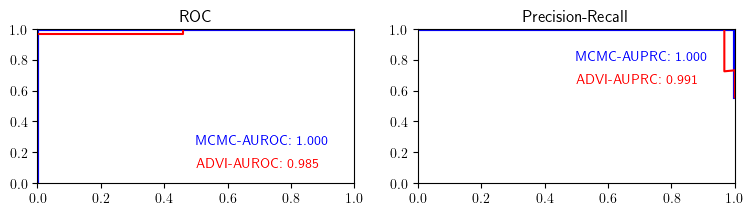

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(fpr, tpr, linewidth=3, color="blue")
ax[0].text(0.5, 0.25, f"MCMC-AUROC: {metrics.auc(fpr, tpr):.3f}", color="blue")

ax[0].plot(fpr_advi, tpr_advi, color="red")
ax[0].text(0.5, 0.1, f"ADVI-AUROC: {metrics.auc(fpr_advi, tpr_advi):.3f}", color="red")

ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(recall, precision, linewidth=3, color="blue")
ax[1].plot(recall_advi, precision_advi, color="red")
ax[1].text(0.5, 0.8, f"MCMC-AUPRC: {metrics.auc(recall, precision):.3f}", color="blue")
ax[1].text(0.5, 0.65, f"ADVI-AUPRC: {metrics.auc(recall_advi, precision_advi):.3f}", color="red")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

_ = plt.savefig("roccurve.pdf", bbox_inches='tight')

In [39]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)  # allows duplicate elements
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

: 

In [ ]:
base = 4
h_vals = [base**-r for r in range(11)]

loo_output = []
success = []

for _ in tqdm(range(10)):
    loo_khat = {}
    reduced_ndx = {}
    high_khat_ndx = {}
    n_sample = [1000]
    records = []
    for n_samples in n_sample:
        sample_ndx = np.random.choice(
            range(fit.stan_variables()["beta0"].shape[0]), size=n_samples, replace=False
        )
        reduced_ndx[n_samples] = {}
        high_khat_ndx[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat[n_samples] = {}
        params_ = fit.stan_variables()
        params_ = {k: v[sample_ndx] for k, v in params_.items()}

        params_["c"] = params_["c"][:, tf.newaxis]
        params_["tau"] = params_["tau"][:, tf.newaxis]
        params_["caux"] = params_["caux"][:, tf.newaxis]
        params_["beta0"] = params_["beta0"][:, tf.newaxis]

        for h in h_vals:
            loo_khat[n_samples][h] = {}
            loo = adaptive_is_loo(lr_model, batch, params_, h, variational=False)
            reduced_ndx[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I", "LL", "KL", "Var", "MM1", "MM2"]:
                loo_khat[n_samples][h][T] = np.array(loo[T]["khat"])

                records += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"],
                    }
                ]
                reduced_ndx[n_samples][h][T] = [
                    loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]
                ]
                # print(reduced_ndx[n_samples][h])

    df = pd.DataFrame(records)
    df["rho_rank"] = np.emath.logn(base, df["h"])
    __df__ = df.explode(["khat", "ndx"])[["ndx", "khat", "T"]]

    counts = {}
    counts["n"] = len(__df__[__df__["T"] != "I0"].ndx.unique())
    for T in transforms:
        ___df__ = __df__.loc[(__df__["T"] == T) & (__df__["khat"] < 0.7)]
        counts[T] = ___df__.groupby("ndx").min().shape[0]
    ___df__ = __df__.loc[
        ((__df__["T"] == "KL") | (__df__["T"] == "Var")) & (__df__["khat"] < 0.7)
    ]
    counts[("KL", "Var")] = ___df__.groupby("ndx").min().shape[0]
    ___df__ = __df__.loc[
        ((__df__["T"] == "MM1") | (__df__["T"] == "MM2") | (__df__["T"] == "LL"))
        & (__df__["khat"] < 0.7)
    ]
    counts[("LL", "MM1", "MM2")] = ___df__.groupby("ndx").min().shape[0]
    ___df__ = __df__.loc[
        ((__df__["T"] == "MM1") | (__df__["T"] == "MM2") | (__df__["T"] == "LL") | (__df__["T"] == "KL") | (__df__["T"] == "Var"))
        & (__df__["khat"] < 0.7)
    ]
    counts[("KL", "Var", "LL", "MM1", "MM2")] = ___df__.groupby("ndx").min().shape[0]
    success += [counts]

 60%|██████    | 6/10 [18:43<12:16, 184.06s/it]

In [41]:
success = pd.DataFrame(success)
#success.to_csv("success.csv")

In [ ]:
success_ = success.copy()
success_.iloc[:, 1:] = -success_.iloc[:, 1:].sub(success_.iloc[:, 0], axis=1)


In [ ]:
success.agg(['mean','std'])

In [ ]:
(-success.iloc[:, 1:].sub(success.iloc[:, 0], axis=0)).agg(['mean','std'])

In [ ]:
df.columns

In [46]:
_df = df.explode(['khat','ndx'])[['rho_rank', 'T', 'ndx', 'khat']]
_df['rho_rank'] *= -1

In [47]:
base_khat = _df[_df['T']=="I"][['ndx', 'khat']].drop_duplicates().to_dict(orient='records')
base_khat = {r['ndx']: r['khat'] for r in base_khat}


In [ ]:
_df

In [ ]:
_df = _df[(_df["T"]!="I") & (_df["T"]!="I0")]
_df[r'$\log(\hat{k}/\hat{k}_0)$'] = _df.apply(lambda x: x.khat/base_khat[x.ndx], axis=1)
_df[r'$log_4(\rho)$'] = _df['rho_rank']

In [50]:
_df = _df[_df[r'$\log(\hat{k}/\hat{k}_0)$']<4]

In [ ]:
from plotnine import ggplot, geom_line, geom_point, aes, stat_smooth, facet_wrap, theme, ylim
from plotnine.data import mtcars


plot = (
    ggplot(_df, aes(r'$log_4(\rho)$', r'$\log(\hat{k}/\hat{k}_0)$', color="T"))
    + geom_line()
    + facet_wrap("ndx")
    + theme(figure_size=(20, 12)) + ylim((-1, 2))
    
)
plot.show()
#plot.save("rho_rank.pdf")

In [ ]:
_df